# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve


2021-11-13 00:55:14.072777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-13 00:55:14.072795: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## LECTURA Y LIMPIEZA DEL DATASET

In [3]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)  #datos de entrenamiento (80% del dataset original)
df_orig.shape

(239, 13)

In [4]:
df_cleaned = df_orig.copy()
feat_train, targ_train = df_orig.drop(["DEATH_EVENT"],axis=1),df_orig["DEATH_EVENT"]
print(feat_train.shape)
print(targ_train.shape)

(239, 12)
(239,)


In [5]:
rfe = RFECV(RandomForestClassifier(n_estimators=2000),scoring="recall",min_features_to_select=5,cv=10,verbose=1,n_jobs=-1)
rfe = rfe.fit(feat_train,targ_train)

Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 featur

In [6]:
for feat in zip(feat_train.columns,rfe.support_):
    print(feat)

('age', True)
('anaemia', True)
('creatinine_phosphokinase', True)
('diabetes', False)
('ejection_fraction', True)
('high_blood_pressure', True)
('platelets', True)
('serum_creatinine', True)
('serum_sodium', True)
('sex', True)
('smoking', False)
('time', True)


## Transformaciones necesarias al df

In [7]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)

#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, CREATININE_PHOSPHOKINASE, EJECTION_FRACTION, PLATELETS, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [8]:
print(df_cleaned.shape)  #6 features + target

(239, 7)


In [9]:
#feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.1,random_state=420)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [10]:
feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]
print(feat_train.shape)
print(targ_train.shape)

(239, 6)
(239,)


In [11]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
feat_train.shape

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

163
76
163
163


## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [12]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---

## ALGUNAS FUNCIONES UTILES PARA GRAFICAR

In [13]:
def aoc_curves (model,feat,targ):
    predicted_p = cross_val_predict(model,feat,targ,cv=10,method="predict_proba")
    fpr, tpr, thres = roc_curve(targ, predicted_p[:,1])
    precisions, recalls, thres = precision_recall_curve(targ, predicted_p[:,1])
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recalls, precisions)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,label = "ROC AOC:{:.3f}".format(roc_auc))
    plt.plot([0,1],[0,1],'--k', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recalls,precisions,label = "PR AOC:{:.3f}".format(pr_auc))
    plt.plot([1,0],[0,1],'--k', alpha=0.5)
    plt.ylabel('Precisión')
    plt.xlabel('Recall')
    plt.title('Curva PR')
    plt.legend()

In [68]:
def train_test_curve (model,param,param_range): 
    train__scores, test__scores = validation_curve(model,feat_train,targ_train,param_name=param,param_range=param_range,scoring=score_metric,cv=20)

    train__mean = np.mean(train__scores,axis=1)
    #train__std = np.std(train__scores,axis=1)
    test__mean = np.mean(test__scores,axis=1)
    #test__std = np.std(test__scores,axis=1)
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,2)
    plt.plot(param_range,train__mean,color='blue',marker='o',markersize=5,label='training recall')
    plt.xscale("log")
    plt.plot(param_range,test__mean,color='green',marker='x',markersize=5,label='test recall') 
    plt.xlabel(param)
    plt.ylabel(score_metric)
    plt.legend(loc='upper left')

In [15]:
def plt_eb (model,rmax):
    means,errors = [],[]
    
    for j in range(2,rmax):
        scorings = cross_val_score(model, feat_train, targ_train,cv=j, scoring=score_metric)
        means.append(scorings.mean())
        errors.append(scorings.std())

    plt.figure(figsize=(15,8))
    plt.xlabel("Cantidad de Folds en CV")
    plt.ylabel("Recall Score")
    plt.title("Mean: {:.3f}+/-{:.3f}".format(np.mean(means),np.mean(errors)))
    plt.ylim((0,1.1))
    plt.errorbar(x=range(2,rmax),y=means,yerr=errors,fmt="-o")

In [16]:
def model_setup (model):
    model.fit(feat_train,targ_train)

    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    print("Cross Validation Score: {:.3f} +/- {:.3f}".format(scoring.mean(),scoring.std()))

    predicted = cross_val_predict(model,feat_train,targ_train,cv=10)
    print(classification_report(targ_train, predicted))
    
    cm = confusion_matrix(targ_train, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

---
---
---

# BASELINE

Cross Validation Score: 0.627 +/- 0.117
              precision    recall  f1-score   support

           0       0.65      0.70      0.67       163
           1       0.68      0.63      0.65       163

    accuracy                           0.66       326
   macro avg       0.66      0.66      0.66       326
weighted avg       0.66      0.66      0.66       326



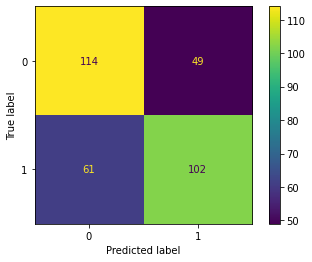

In [61]:
percep1 = Perceptron(fit_intercept=False, max_iter=40000)
model_setup(percep1)

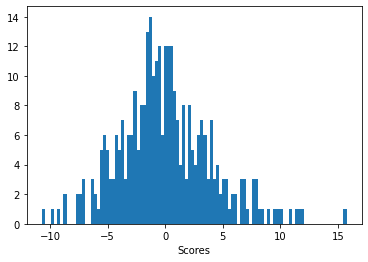

In [59]:
y_scores = cross_val_predict(percep1, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

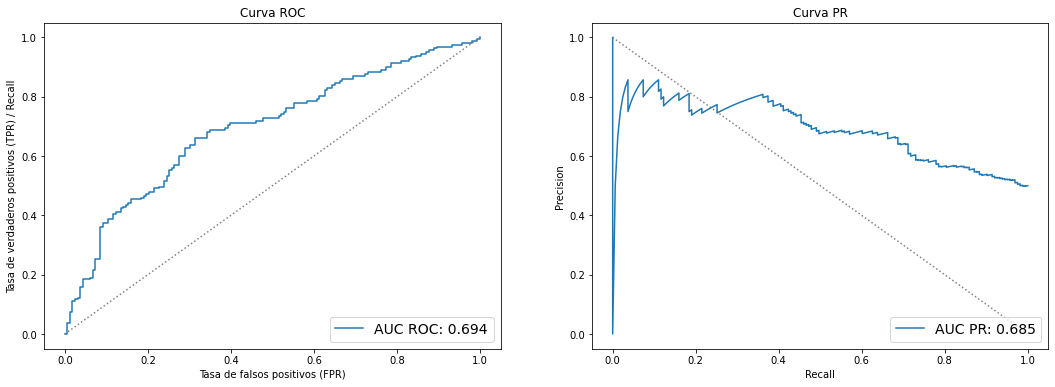

In [63]:
precisions, recalls, thresholds = precision_recall_curve(targ_train, y_scores)
fpr, tpr, thresholds = roc_curve(targ_train, y_scores)

auc_score_PR = auc(recalls, precisions)
auc_score_ROC = auc(fpr,tpr)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(122)
ax.plot(recalls,precisions, label = "AUC PR: {:.3f}".format(auc_score_PR))
ax.plot([0, 1], [1, 0], color='0.5', ls=':')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Curva PR')
ax.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(121)
ax2.plot(fpr, tpr,label = "AUC ROC: {:.3f}".format(auc_score_ROC))
ax2.plot([0, 1], [0, 1], color='0.5', ls=':')
ax2.set_xlabel('Tasa de falsos positivos (FPR)')
ax2.set_ylabel('Tasa de verdaderos positivos (TPR) / Recall')
ax2.set_title('Curva ROC')
ax2.legend(loc='lower right', fontsize=14)

Cross Validation Score: 0.711 +/- 0.116
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       163
           1       0.64      0.71      0.68       163

    accuracy                           0.66       326
   macro avg       0.66      0.66      0.66       326
weighted avg       0.66      0.66      0.66       326



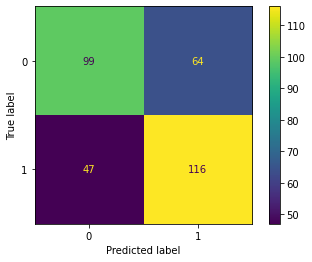

In [64]:
percep2 = Perceptron(fit_intercept=False, max_iter=40000,penalty="l2",random_state=420,alpha=1e-5,eta0=0.05)
model_setup(percep2)

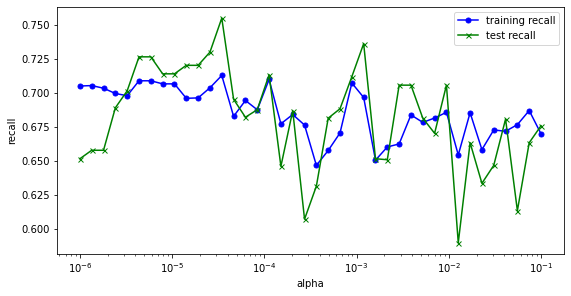

In [58]:
train_test_curve(per_model,"alpha",np.logspace(-6,-1,40))

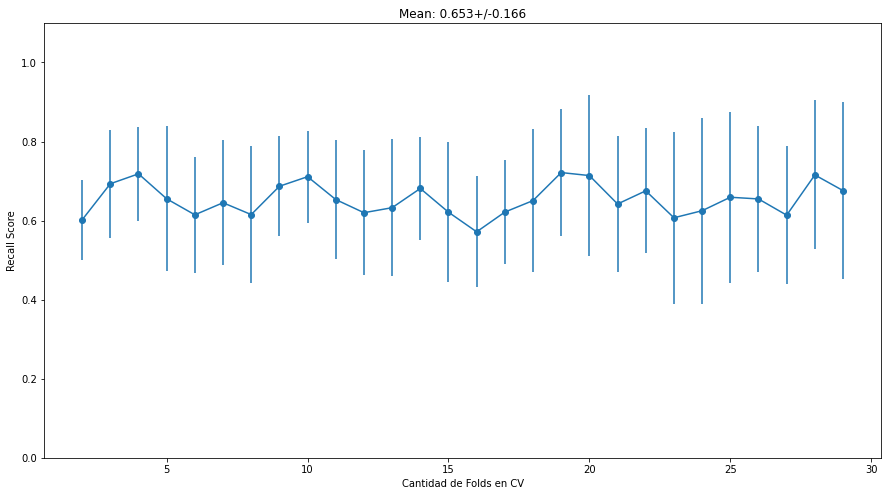

In [20]:
plt_eb(per_model,30)

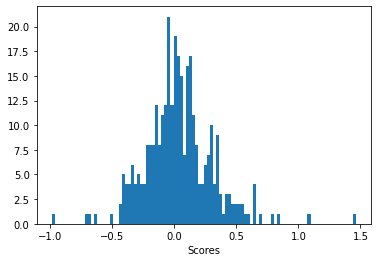

In [65]:
y_scores = cross_val_predict(percep2, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

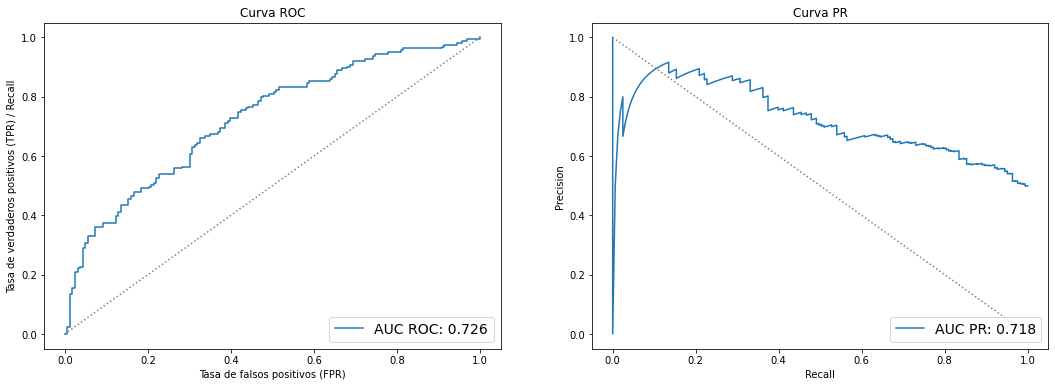

In [66]:
precisions, recalls, thresholds = precision_recall_curve(targ_train, y_scores)
fpr, tpr, thresholds = roc_curve(targ_train, y_scores)

auc_score_PR = auc(recalls, precisions)
auc_score_ROC = auc(fpr,tpr)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(122)
ax.plot(recalls,precisions, label = "AUC PR: {:.3f}".format(auc_score_PR))
ax.plot([0, 1], [1, 0], color='0.5', ls=':')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Curva PR')
ax.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(121)
ax2.plot(fpr, tpr,label = "AUC ROC: {:.3f}".format(auc_score_ROC))
ax2.plot([0, 1], [0, 1], color='0.5', ls=':')
ax2.set_xlabel('Tasa de falsos positivos (FPR)')
ax2.set_ylabel('Tasa de verdaderos positivos (TPR) / Recall')
ax2.set_title('Curva ROC')
ax2.legend(loc='lower right', fontsize=14)

# LOGISTIC REGRESSION

## BEST PARAMS => C=2 -> Recall = 0.811+/-0.066

Cross Validation Score: 0.811 +/- 0.066
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       163
           1       0.71      0.81      0.76       163

    accuracy                           0.74       326
   macro avg       0.75      0.74      0.74       326
weighted avg       0.75      0.74      0.74       326



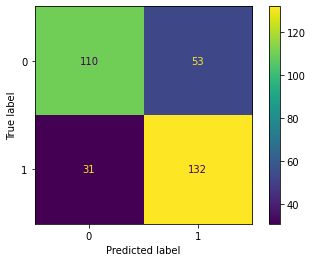

In [21]:
lr_model = LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=2)
model_setup(lr_model)

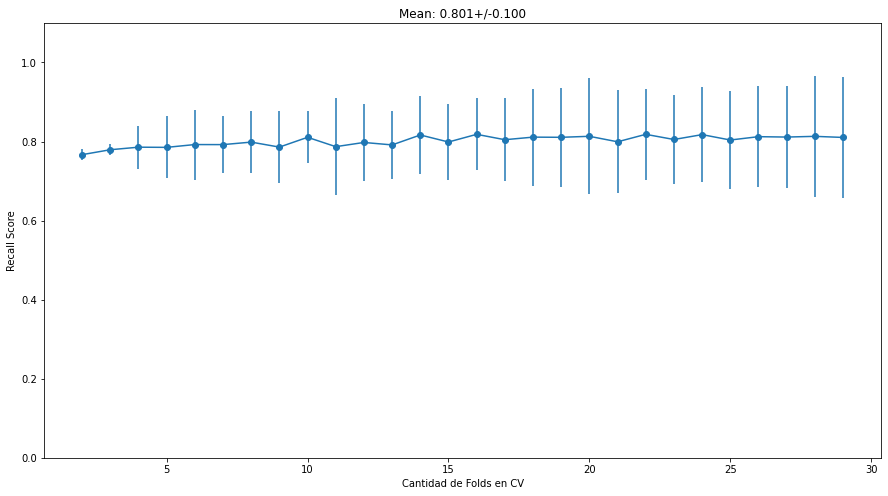

In [22]:
plt_eb(lr_model,30)

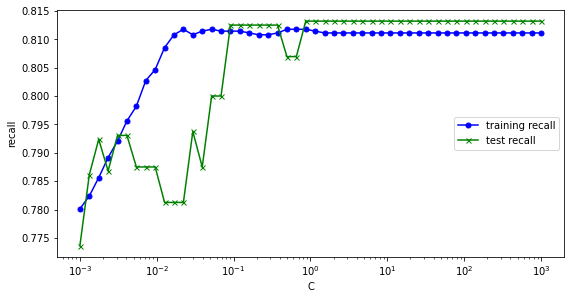

In [23]:
train_test_curve(lr_model,"C",np.logspace(-3,3,50))

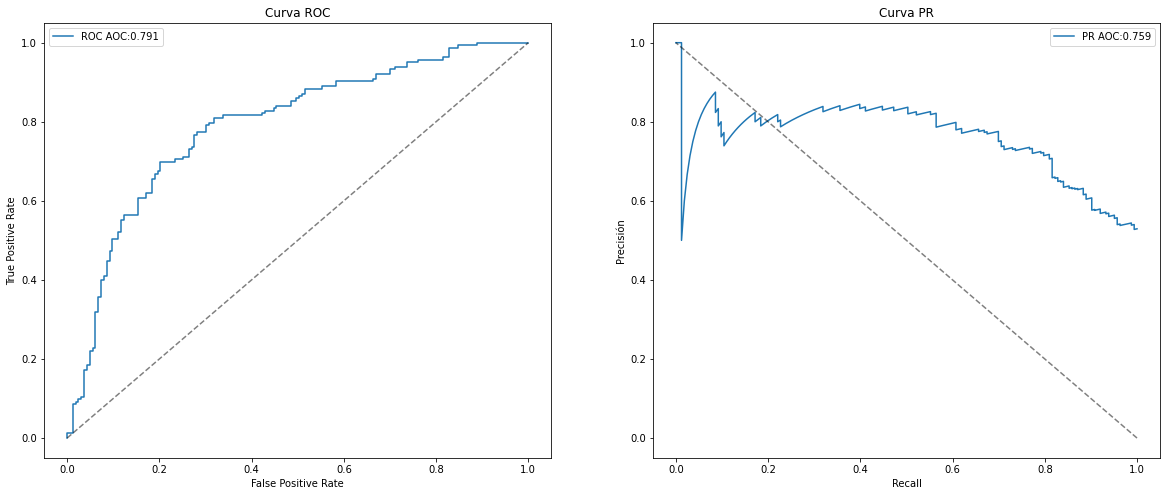

In [24]:
aoc_curves(lr_model,feat_train,targ_train)

---

# SVM

## BEST PARAMS => C = 0.85, Gamma = 0.61 -> Recall = 0.872+/-0.075

Cross Validation Score: 0.872 +/- 0.075
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       163
           1       0.76      0.87      0.81       163

    accuracy                           0.80       326
   macro avg       0.81      0.80      0.80       326
weighted avg       0.81      0.80      0.80       326



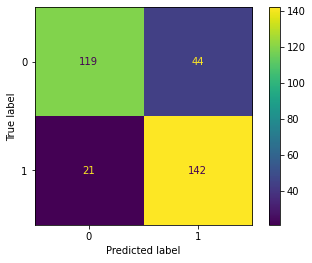

In [69]:
svm_model = SVC(probability=True,gamma=0.61,C=0.85)
model_setup(svm_model)

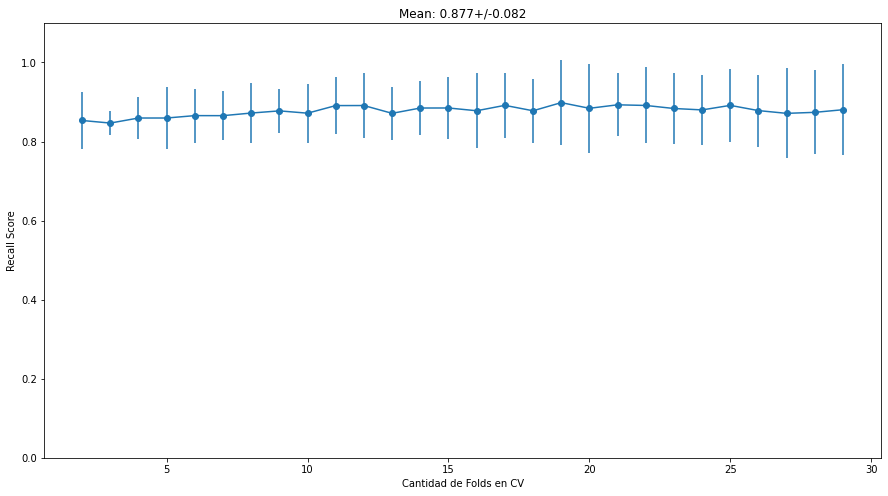

In [70]:
plt_eb(svm_model,30)

In [75]:
hyperparam = {"C":np.logspace(-2,0,30),"gamma":np.logspace(-2,0,20)}
svm_model = SVC(break_ties=True,probability=True)
svm_grilla = GridSearchCV(svm_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
svm_grilla.fit(feat_train,targ_train)
print(svm_grilla.best_params_)
svm_model = svm_grilla.best_estimator_

{'C': 0.727895384398315, 'gamma': 1.0}


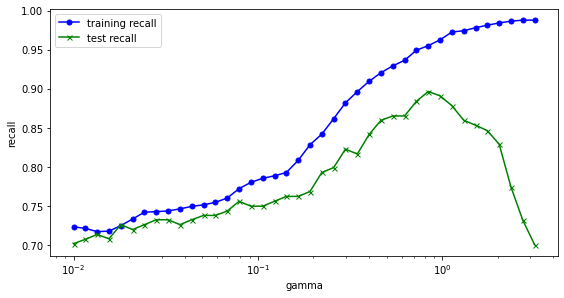

In [72]:
train_test_curve(svm_model,"gamma",np.logspace(-2,0.5,40))

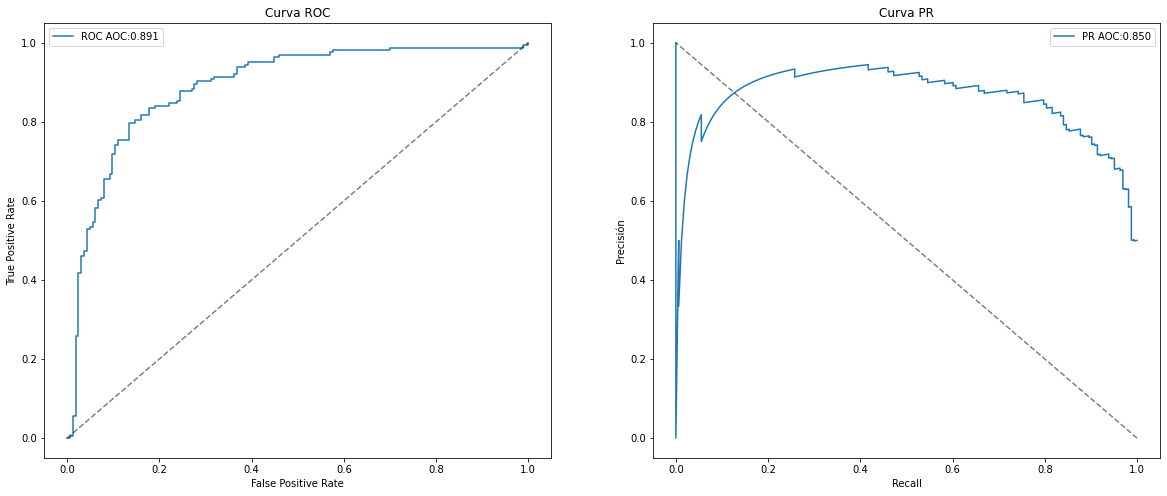

In [73]:
aoc_curves(svm_model,feat_train,targ_train)

---

# Random Forest

## BEST PARAMS => n_estimators = 400, min_impurity_decrease = 2e-4 -> Recall = 0.872+/-0.083

Cross Validation Score: 0.861 +/- 0.107
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       163
           1       0.82      0.86      0.84       163

    accuracy                           0.83       326
   macro avg       0.84      0.83      0.83       326
weighted avg       0.84      0.83      0.83       326



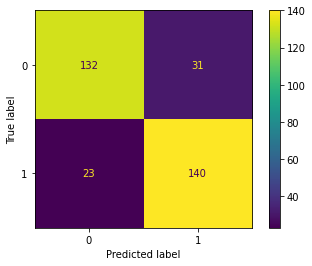

In [76]:
rf_model = RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)
model_setup(rf_model)

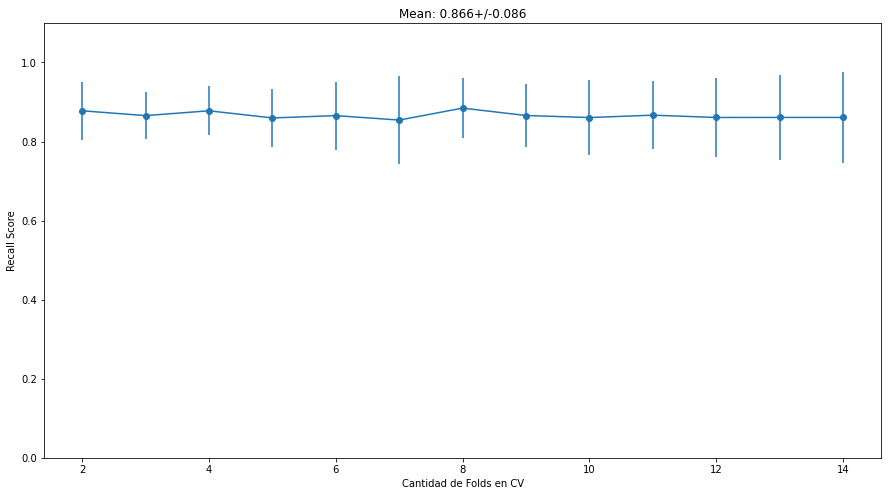

In [77]:
plt_eb(rf_model,15)

In [78]:
hyperparam = {"n_estimators":[40],"max_depth":[6],"min_samples_split":[40]}
rf_model = RandomForestClassifier()
rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
rf_grilla.fit(feat_train,targ_train)
rf_model = rf_grilla.best_estimator_
print(rf_grilla.best_params_)

{'max_depth': 6, 'min_samples_split': 40, 'n_estimators': 40}


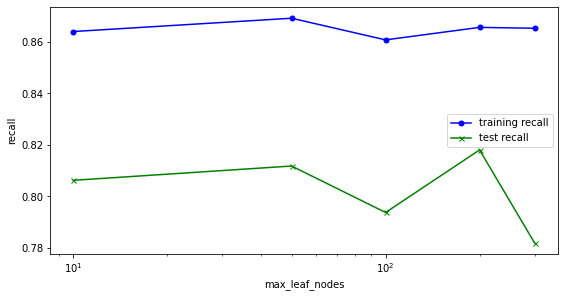

In [33]:
train_test_curve(rf_model,"max_leaf_nodes",[10,50,100,200,300])

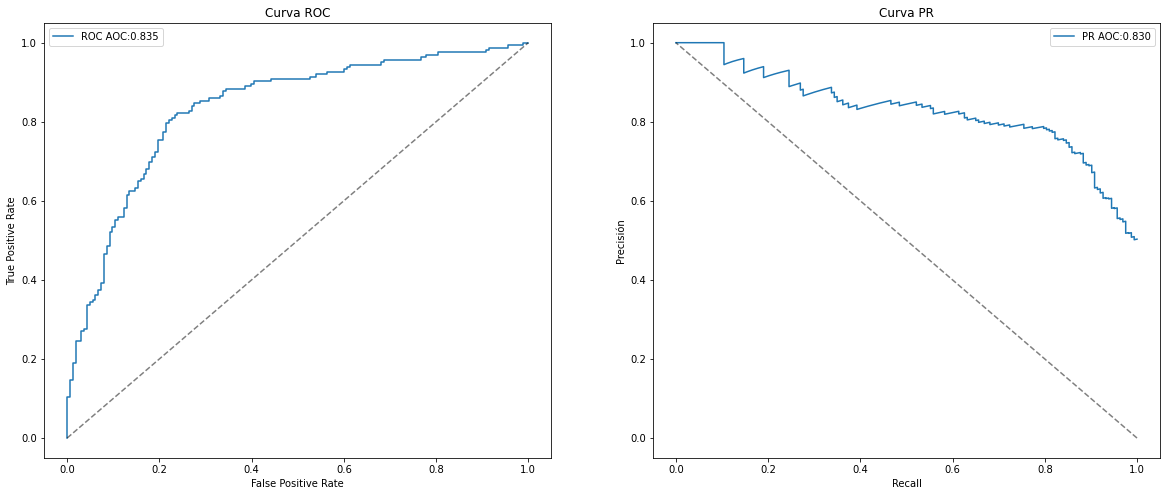

In [79]:
aoc_curves(rf_model,feat_train,targ_train)

---

# ADA BOOSTING

Cross Validation Score: 0.799 +/- 0.098
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       163
           1       0.73      0.79      0.76       163

    accuracy                           0.75       326
   macro avg       0.75      0.75      0.75       326
weighted avg       0.75      0.75      0.75       326



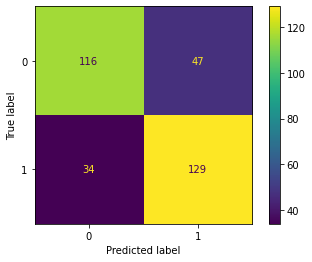

In [80]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=0.2)
model_setup(ada_model)

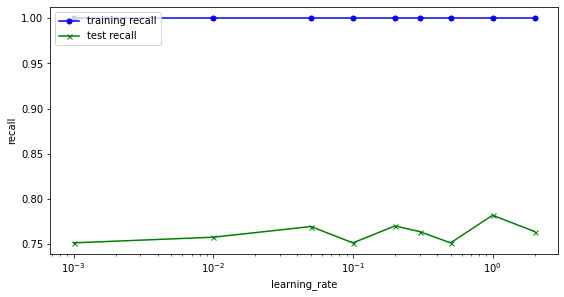

In [81]:
train_test_curve(ada_model,"learning_rate",[0.001,0.01,0.05,0.1,0.2,0.3,0.5,1,2])

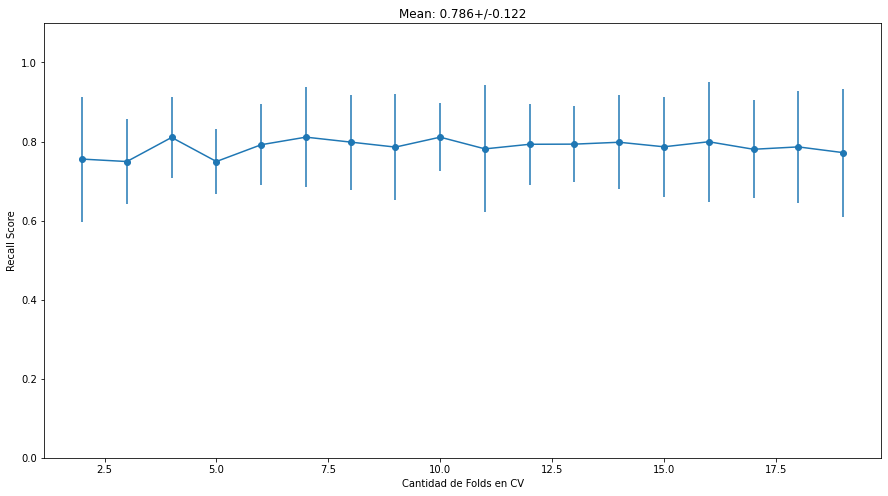

In [82]:
plt_eb(ada_model,20)

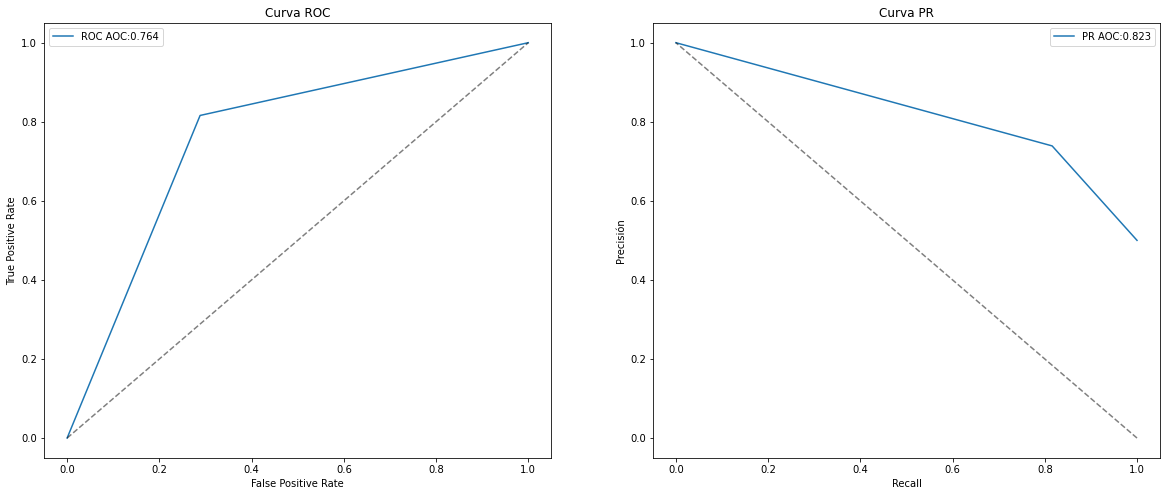

In [83]:
aoc_curves(ada_model,feat_train,targ_train)


---


# GRADIENT BOOSTING

## BEST PARAMS => n_estimators = 500, learning_rate = 0.05,objective="binary:hinge" -> Recall = 0.843+/-0.158

### Cambia levemente la metodologia, usa early stopping

In [84]:
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train,random_state=420)
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC

In [85]:
xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=500)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric="error",early_stopping_rounds=20,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std())) 

[0]	validation_0-error:0.52459	validation_1-error:0.42683
[1]	validation_0-error:0.52459	validation_1-error:0.42683
[2]	validation_0-error:0.52459	validation_1-error:0.42683
[3]	validation_0-error:0.52459	validation_1-error:0.42683
[4]	validation_0-error:0.52459	validation_1-error:0.42683
[5]	validation_0-error:0.52459	validation_1-error:0.42683
[6]	validation_0-error:0.52459	validation_1-error:0.42683
[7]	validation_0-error:0.52459	validation_1-error:0.42683
[8]	validation_0-error:0.52459	validation_1-error:0.42683
[9]	validation_0-error:0.52459	validation_1-error:0.42683
[10]	validation_0-error:0.52459	validation_1-error:0.42683
[11]	validation_0-error:0.18443	validation_1-error:0.29268
[12]	validation_0-error:0.15574	validation_1-error:0.29268
[13]	validation_0-error:0.11885	validation_1-error:0.26829
[14]	validation_0-error:0.10656	validation_1-error:0.28049
[15]	validation_0-error:0.10656	validation_1-error:0.26829
[16]	validation_0-error:0.10246	validation_1-error:0.26829
[17]	va

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       163
           1       0.79      0.81      0.80       163

    accuracy                           0.80       326
   macro avg       0.80      0.80      0.80       326
weighted avg       0.80      0.80      0.80       326



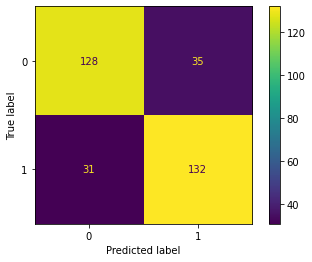

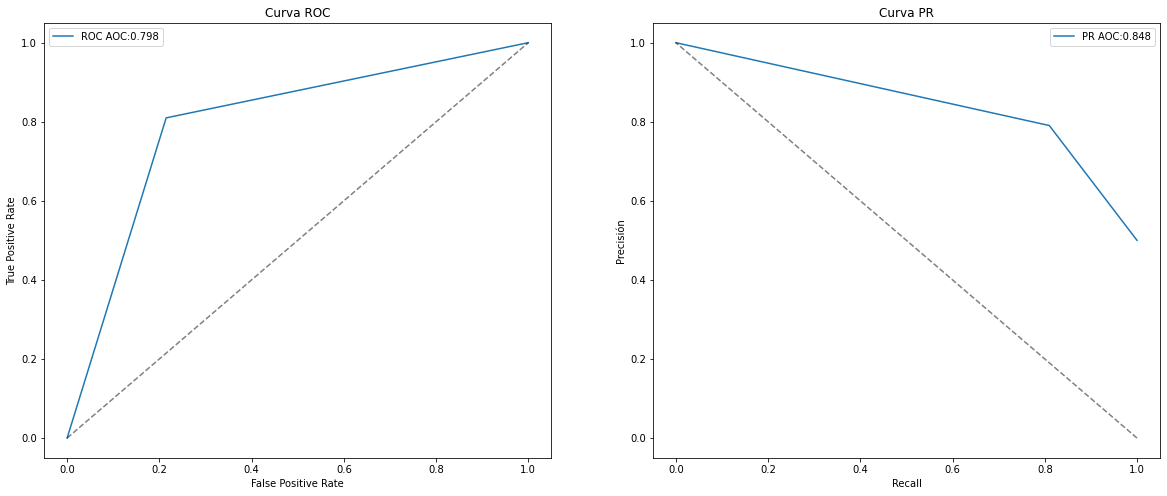

In [86]:
xgbc_predicted = cross_val_predict(xgbc_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, xgbc_predicted))
cm = confusion_matrix(targ_train, xgbc_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
aoc_curves(xgbc_model,feat_train,targ_train)

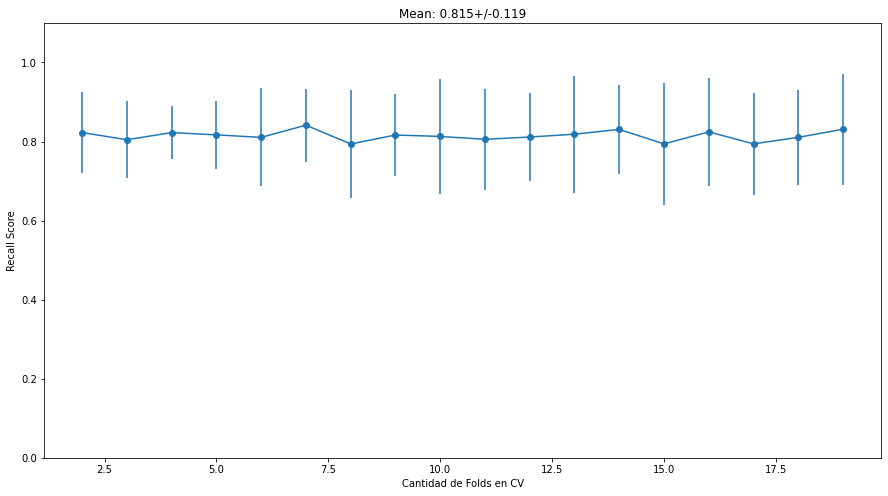

In [41]:
plt_eb(xgbc_model,20)

---

# VOTING

In [87]:
vot_hard_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svm_model)],
    voting='hard')
vot_soft_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svm_model)],
    voting='soft')

## HARD

Cross Validation Score: 0.842 +/- 0.059
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       163
           1       0.77      0.85      0.81       163

    accuracy                           0.80       326
   macro avg       0.80      0.80      0.80       326
weighted avg       0.80      0.80      0.80       326



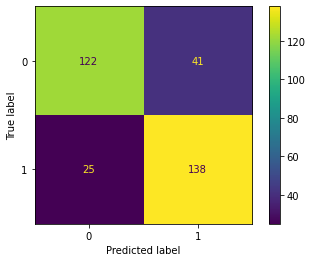

In [88]:
model_setup(vot_hard_model)

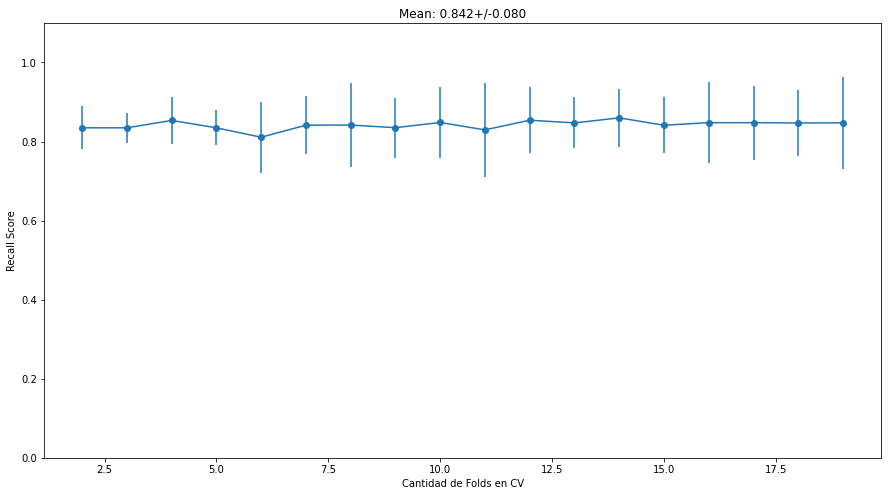

In [44]:
plt_eb(vot_hard_model,20)

## SOFT

Cross Validation Score: 0.854 +/- 0.066
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       163
           1       0.79      0.84      0.82       163

    accuracy                           0.81       326
   macro avg       0.81      0.81      0.81       326
weighted avg       0.81      0.81      0.81       326



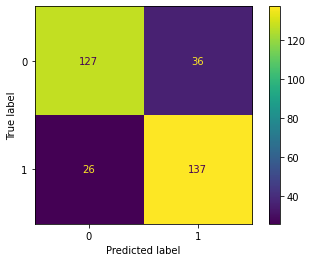

In [90]:
model_setup(vot_soft_model)

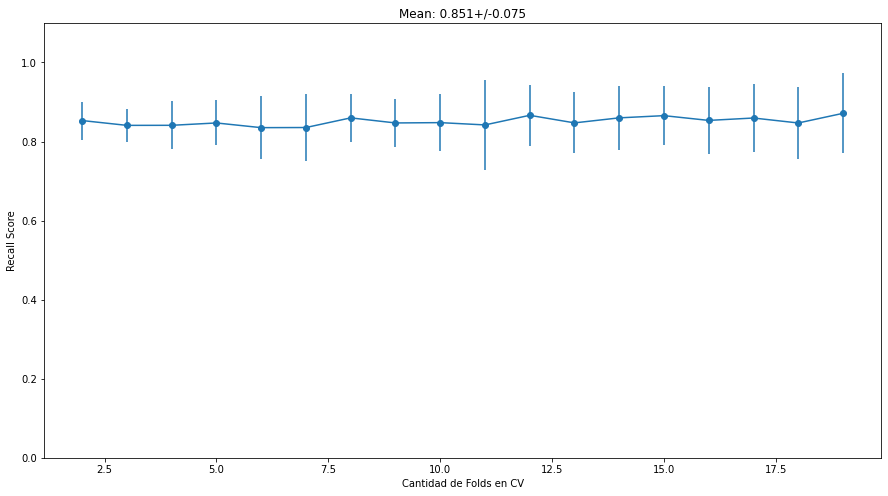

In [91]:
plt_eb(vot_soft_model,20)

---

# RED NEURONAL SIMPLE

In [46]:
keras.backend.clear_session()

In [47]:
input = keras.layers.Input(shape=[6,])
flatten = keras.layers.Flatten()(input)
hidden1 = keras.layers.Dense(100, activation="relu")(flatten)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = keras.models.Model(inputs=[input], outputs=[output])

2021-11-13 00:58:48.855375: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-13 00:58:48.856621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 00:58:48.857081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.65GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-11-13 00:58:48.857210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-13 00:58:48.857310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic librar

In [48]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(feat_train, targ_train, epochs=2000, batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)])

2021-11-13 00:58:48.990251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-13 00:58:49.009297: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3997760000 Hz


Epoch 1/2000
9/9 [==============================] - 1s 20ms/step - loss: 0.6704 - recall: 0.2371 - val_loss: 0.7627 - val_recall: 0.2879
Epoch 2/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.6055 - recall: 0.4021 - val_loss: 0.7715 - val_recall: 0.4242
Epoch 3/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.5653 - recall: 0.4948 - val_loss: 0.7456 - val_recall: 0.4848
Epoch 4/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5379 - recall: 0.5979 - val_loss: 0.6785 - val_recall: 0.5606
Epoch 5/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5229 - recall: 0.6289 - val_loss: 0.6688 - val_recall: 0.5758
Epoch 6/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5076 - recall: 0.6495 - val_loss: 0.6874 - val_recall: 0.6212
Epoch 7/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.4989 - recall: 0.6598 - val_loss: 0.6627 - val_recall: 0.6212
Epoch 8/2000
9/9 [=============================

In [50]:
model.evaluate(feat_train,targ_train)

11/11 [==============================] - 0s 557us/step - loss: 0.0589 - recall: 0.9755


[0.05888836458325386, 0.9754601120948792]

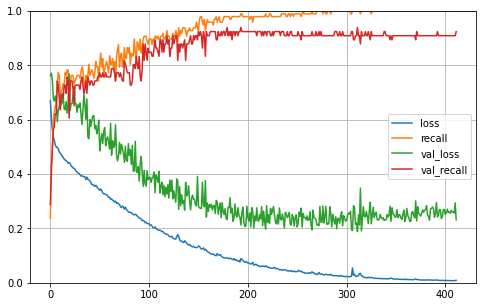

In [51]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

(array([155.,   5.,   4.,   2.,   1.,   1.,   1.,   0.,  10., 147.]),
 array([9.838932e-10, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

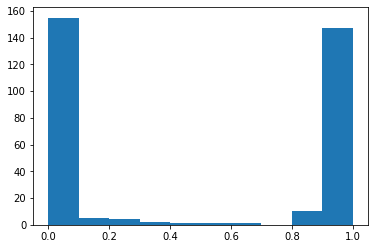

In [52]:
plt.hist(model.predict(feat_train))

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

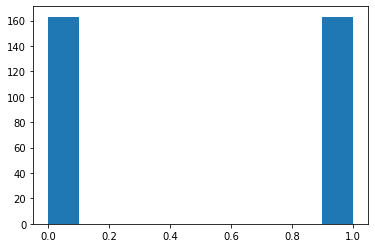

In [53]:
plt.hist(targ_train)

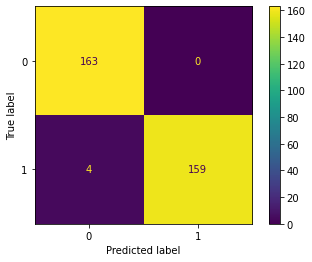

In [54]:
cm = confusion_matrix(targ_train, model.predict(feat_train)>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()